In [11]:
from vtl.Readfile import Readfile
# from spec_id import 
import grizli
from astropy.table import Table
from astropy.io import fits
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sea
from time import time
import pysynphot as S
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [51]:
def Scale_model(D, sig, M):
    C = np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
    return C


class Gen_sim(object):
    def __init__(self, galaxy_id, redshift, metal, age, tau, pad=100):
        self.galaxy_id = galaxy_id
        self.redshift = redshift
        self.metal = metal
        self.age = age
        self.tau = tau
        self.pad = pad

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.pad - Grizli uses this to add extra pixels to the edge of an image to account for galaxies near the 
                   edge, 100 is usually enough
        **
        self.beam - information used to make models
        **
        self.gal_wv - output wavelength array of galaxy
        **
        self.gal_wv_rf - output wavelength array in restframe
        **
        self.gal_fl - output flux array of galaxy
        **
        self.gal_er - output error array of galaxy
        **
        self.fl - output flux array of model used for simulation
        **
        self.flx_err - output flux array of model perturb by the galaxy's 1 sigma errors
        **
        self.mfl - output flux array of model generated to fit against 
        """

        gal_wv, gal_fl, gal_er = np.load('../spec_stacks_june14/%s_stack.npy' % self.galaxy_id)
        self.flt_input = '../data/galaxy_flts/%s_flt.fits' % self.galaxy_id

        IDX = [U for U in range(len(gal_wv)) if 7900 <= gal_wv[U] <= 11300]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]

        ## Create Grizli model object
        sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=self.flt_input,
                                         force_grism='G102', pad=self.pad)

        sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

        keep = sim_g102.catalog['mag'] < 29
        c = sim_g102.catalog

        sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

        ## Grab object near the center of the image
        dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
        ix = np.argmin(dr)
        id = sim_g102.catalog['id'][ix]

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[id]['A'], conf=sim_g102.conf)
        
        ## create basis model for sim
        
        model = '../../../fsps_models_for_fit/fsps_spec/m%s_a%s_t%s_spec.npy' % (self.metal, self.age, self.tau)

        wave, fl = np.load(model)
        spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
        spec = spec.redshift(self.redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
        spec.convert('flam')
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[spec.wave, spec.flux])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model, bin=0)

        ifl = interp1d(w, f)(self.gal_wv)

        ## Get sensitivity function
        fwv, ffl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]
        filt = interp1d(fwv, ffl)(self.gal_wv)

        adj_ifl = ifl /filt

        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl


    def Perturb_flux(self):
        self.flx_err = self.fl + np.random.normal(0,self.gal_er)


    def Sim_spec(self, metal, age, tau):
        model = '../../../fsps_models_for_fit/fsps_spec/m%s_a%s_t%s_spec.npy' % (metal, age, tau)

        wave, fl = np.load(model)
        spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
        spec = spec.redshift(self.redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
        spec.convert('flam')
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[spec.wave, spec.flux])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model, bin=0)

        ifl = interp1d(w, f)(self.gal_wv)

        ## Get sensitivity function
        fwv, ffl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]
        filt = interp1d(fwv, ffl)(self.gal_wv)

        adj_ifl = ifl /filt

        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.mfl = C * adj_ifl
        
    def Pickle_spec(self,metal,age,tau,name):
        mfl = np.zeros([len(metal)*len(age)*len(tau),len(self.gal_wv)])
        for i in range(len(metal)):
            for ii in range(len(age)):
                for iii in range(len(tau)):
                    self.Sim_spec(metal[i], age[ii], tau[iii])
                    mfl[i*len(age)*len(tau)+ii*len(tau)+iii]=self.mfl
        
        np.save('../data/' + name,mfl)    


########################################################################

        
def MC_fit(galaxy, metal, age, tau, sim_m, sim_a, sim_t, specz, name, pkl_spec = None,repeats = 100, age_conv = '../data/tau_scale_ntau.dat'):
    mlist = []
    alist = []    
    ml_mean = []
    al_mean = []    
    ml_mode = []
    al_mode = []
    cPZ = np.ones(len(metal))
    cPt = np.ones(len(age))
    cP = np.ones([len(age),len(metal)])
    
    ultau = np.append(0, np.power(10, np.array(tau[1:]) - 9))
    iZ = np.linspace(metal[0], metal[-1], 100)
    it = np.linspace(age[0], age[-1], 100)
    spec = Gen_sim(galaxy,specz,sim_m,sim_a,sim_t)
       
    ###############Get indicies
    IDF = []
    for i in range(len(spec.gal_wv_rf)):
        if 3800 <= spec.gal_wv_rf[i] <= 3850 or 3910 <= spec.gal_wv_rf[i] <= 4030 or 4080 <= spec.gal_wv_rf[i] <= 4125 \
                or 4250 <= spec.gal_wv_rf[i] <= 4385 or 4515 <= spec.gal_wv_rf[i] <= 4570 or 4810 <= spec.gal_wv_rf[i]\
                <= 4910 or 4975 <= spec.gal_wv_rf[i] <= 5055 or 5110 <= spec.gal_wv_rf[i] <= 5285:
            IDF.append(i)

    IDC = []
    for i in range(len(spec.gal_wv_rf)):
        if spec.gal_wv_rf[0] <= spec.gal_wv_rf[i] <= 3800 or 3850 <= spec.gal_wv_rf[i] <= 3910 or 4030 <= \
                spec.gal_wv_rf[i] <= 4080 or 4125 <= spec.gal_wv_rf[i] <= 4250 or 4385 <= spec.gal_wv_rf[i] <= 4515 or \
                4570 <= spec.gal_wv_rf[i] <= 4810 or 4910 <= spec.gal_wv_rf[i] <= 4975 or 5055 <= spec.gal_wv_rf[i] <= \
                5110 or 5285 <= spec.gal_wv_rf[i] <= spec.gal_wv_rf[-1]:
            IDC.append(i)


    ###############Get model list
    mfl_f = np.zeros([len(metal)*len(age)*len(tau),len(IDF)])
    mfl_c = np.zeros([len(metal)*len(age)*len(tau),len(IDC)])
    
    if pkl_spec == None:
        for i in range(len(metal)):
            for ii in range(len(age)):
                for iii in range(len(tau)):
                    spec.Sim_spec(metal[i], age[ii], tau[iii])
                    mfl_f[i*len(age)*len(tau)+ii*len(tau)+iii]=spec.fl[IDF]
                    mfl_c[i*len(age)*len(tau)+ii*len(tau)+iii]=spec.fl[IDC]

    else:
        mfl = np.load(pkl_spec)
        for i in range(len(mfl)):
            mfl_f[i]=mfl[i][IDF]
            mfl_c[i]=mfl[i][IDC]

    convtau = np.array([0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2,
                        9.23, 9.26, 9.28, 9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48])
    convage = np.arange(.5, 6.1, .1)

    mt = [U for U in range(len(convtau)) if convtau[U] in tau]
    ma = [U for U in range(len(convage)) if np.round(convage[U], 1) in np.round(age, 1)]

    convtable = Readfile(age_conv)
    scale = convtable[mt[0]:mt[-1] + 1, ma[0]:ma[-1] + 1]

    overhead = np.zeros(len(scale)).astype(int)
    for i in range(len(scale)):
        amt = []
        for ii in range(len(age)):
            if age[ii] > scale[i][-1]:
                amt.append(1)
        overhead[i] = sum(amt)

    for xx in range(repeats):
        spec.Perturb_flux()
        
        Fchi = np.sum(((spec.flx_err[IDF] - mfl_f) / spec.gal_er[IDF]) ** 2, axis=1).reshape([len(metal), len(age), len(tau)]).astype(
            np.float128).T
        Cchi = np.sum(((spec.flx_err[IDC] - mfl_c) / spec.gal_er[IDC]) ** 2, axis=1).reshape([len(metal), len(age), len(tau)]).astype(
            np.float128).T
        
        ######## Reshape likelihood to get average age instead of age when marginalized
        newCchi = np.zeros(Cchi.shape)
        newFchi = np.zeros(Fchi.shape)
    
        for i in range(len(Cchi)):
            if i == 0:
                newCchi[i] = Cchi[i]
                newFchi[i] = Fchi[i]
            else:
                cframe = interp2d(metal, scale[i], Cchi[i])(metal, age[:-overhead[i]])
                newCchi[i] = np.append(cframe, np.repeat([np.repeat(1E5, len(metal))], overhead[i], axis=0), axis=0)
    
                fframe = interp2d(metal, scale[i], Fchi[i])(metal, age[:-overhead[i]])
                newFchi[i] = np.append(fframe, np.repeat([np.repeat(1E5, len(metal))], overhead[i], axis=0), axis=0)

        ####### Create normalize probablity marginalized over tau
        cprob = np.exp(-newCchi.T.astype(np.float128) / 2)
    
        Pc = np.trapz(cprob, ultau, axis=2)
        Cc = np.trapz(np.trapz(Pc, age, axis=1), metal)
    
        fprob = np.exp(-newFchi.T.astype(np.float128) / 2)
    
        Pf = np.trapz(fprob, ultau, axis=2)
        Cf = np.trapz(np.trapz(Pf, age, axis=1), metal)
    
        comb_prob = cprob / Cc * fprob / Cf
    
        prob = np.trapz(comb_prob, ultau, axis=2)
        C0 = np.trapz(np.trapz(prob, age, axis=1), metal)
        prob /= C0
    
        #### Get Z and t posteriors
        PZ = np.trapz(prob, age, axis=1)
        Pt = np.trapz(prob.T, metal,axis=1)

        iPZ = interp1d(metal, PZ)(iZ)  
        iPt = interp1d(age, Pt)(it)
        
        med = 0
        for i in range(len(iZ)):
            e = np.trapz(iPZ[0:i + 1], iZ[0:i + 1])
            if med == 0:
                if e >= .5:
                    med = iZ[i]
                    break
        mlist.append(med)
                    
        med = 0
        for i in range(len(it)):
            e = np.trapz(iPt[0:i + 1], it[0:i + 1])
            if med == 0:
                if e >= .5:
                    med = it[i]
                    break
        alist.append(med)
        
        ml_mean.append(np.trapz(PZ * metal,metal))
        al_mean.append(np.trapz(Pt * age, age))
        
        ml_mode.append(metal[np.argmax(PZ)])
        al_mode.append(age[np.argmax(Pt)])

        cPZ = cPZ * PZ
        cPt = cPt * Pt
        cP = cP * prob.T

        plt.figure(figsize=[8,8])
        plt.plot(metal,PZ)
        plt.axvline(0.019)
        plt.show()
        plt.close()
        
        
        plt.figure(figsize=[8,8])
        plt.plot(age,Pt)
        plt.axvline(3.5)
        plt.show()
        plt.close()

    np.save('../mcerr/' + name + 'med',[mlist, alist])
    np.save('../mcerr/' + name + 'mean',[ml_mean, al_mean])
    np.save('../mcerr/' + name + 'mode',[ml_mode, al_mode])
    np.save('../mcerr/' + name + 'pz',cPZ)
    np.save('../mcerr/' + name + 'pt',cPt)
    np.save('../mcerr/' + name + 'p',cP)

    return

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


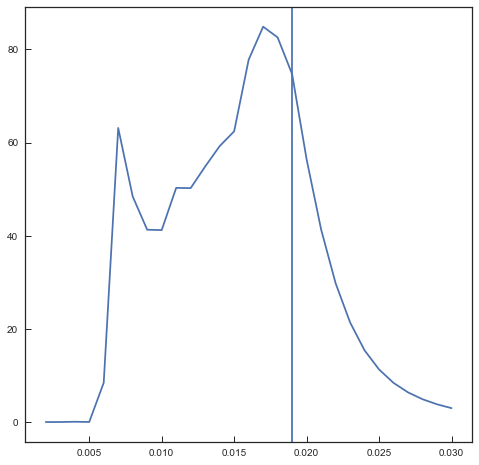

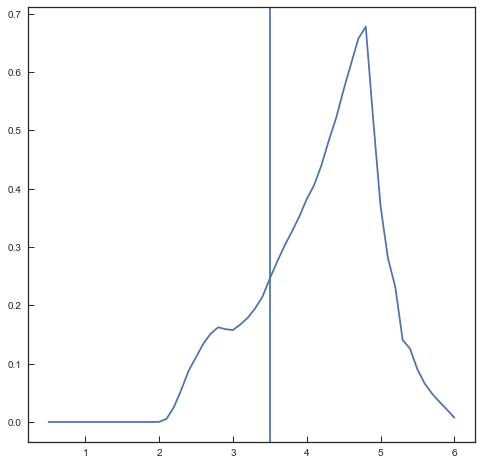

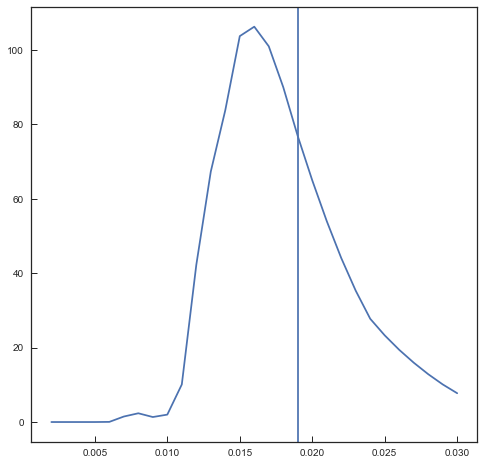

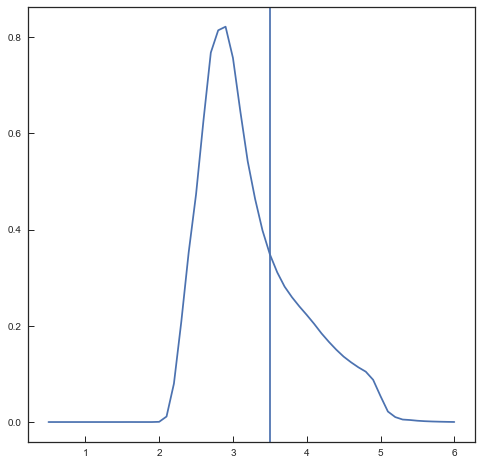

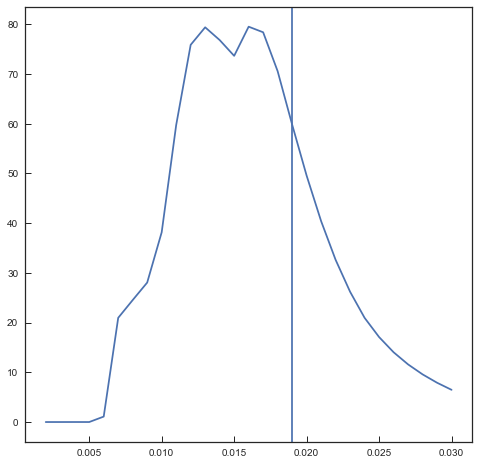

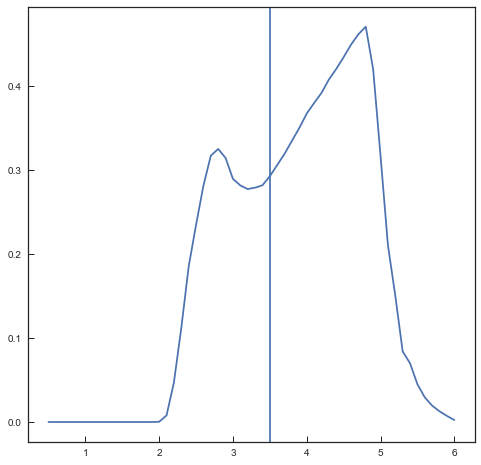

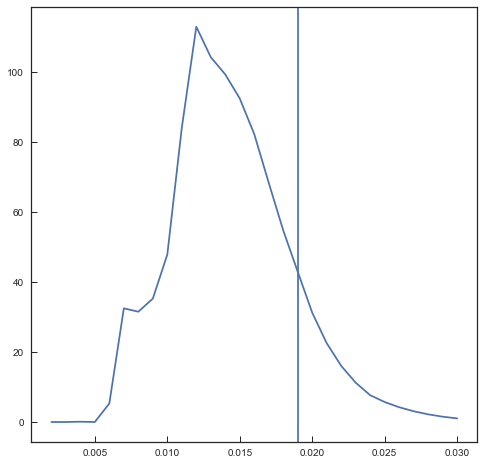

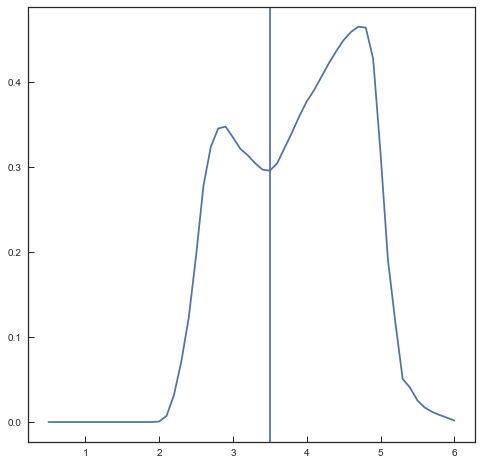

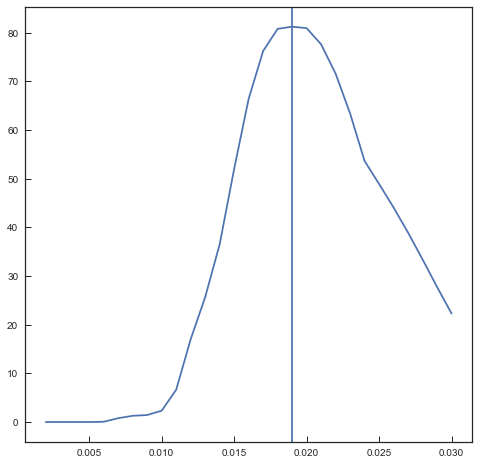

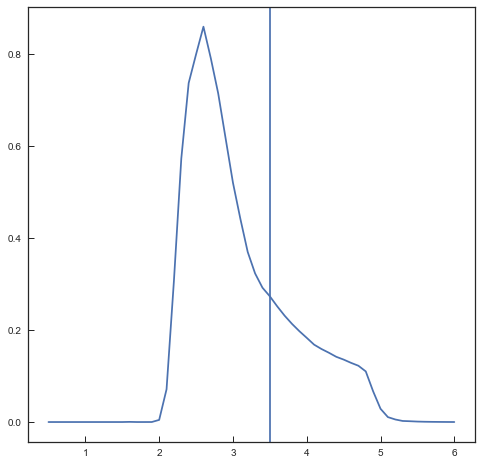

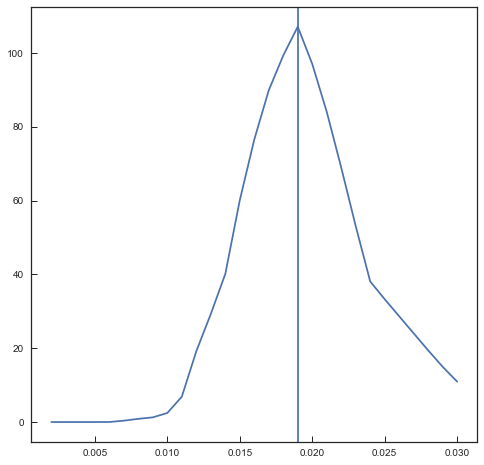

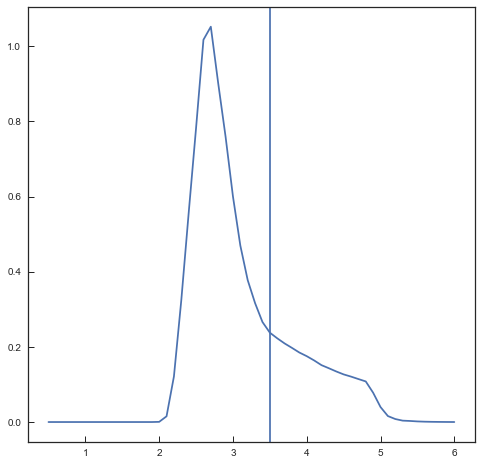

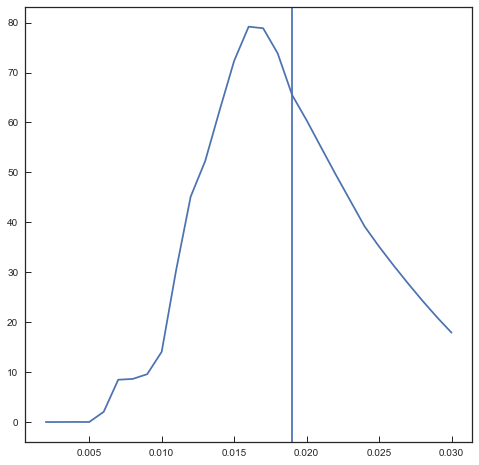

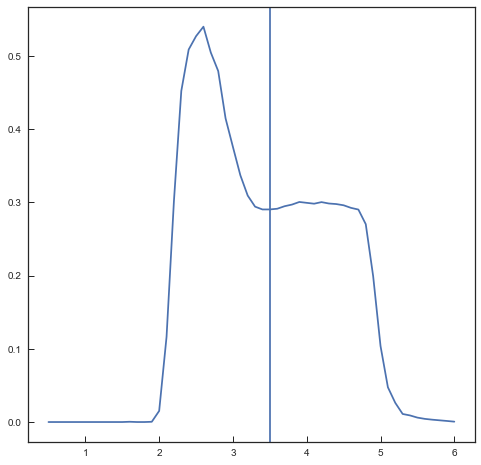

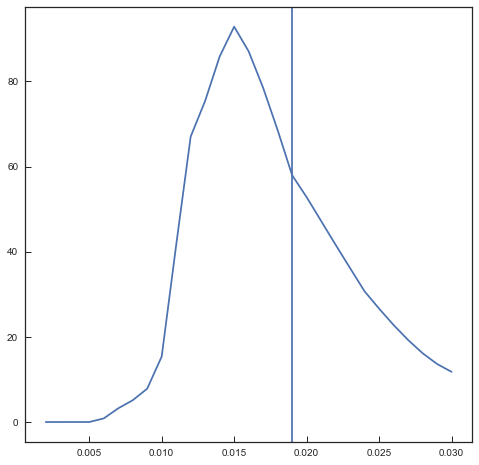

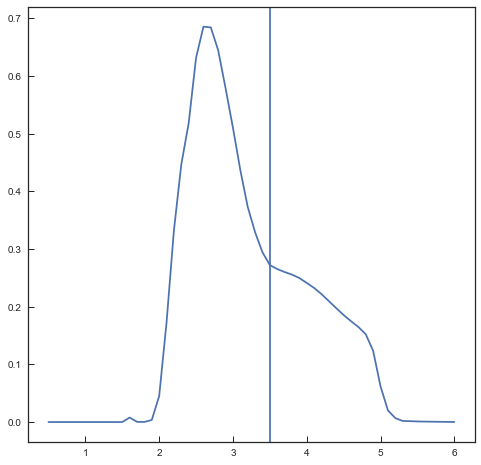

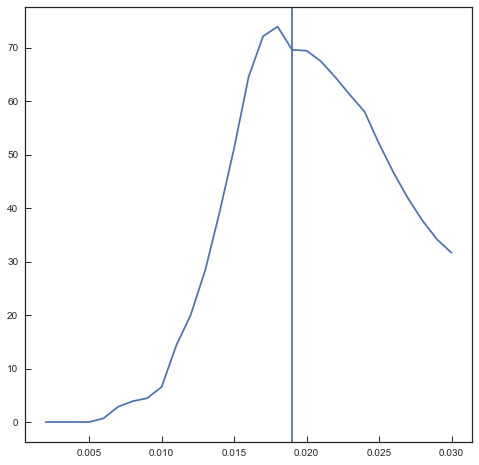

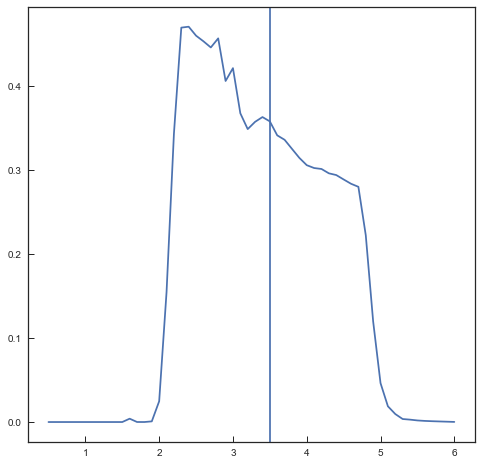

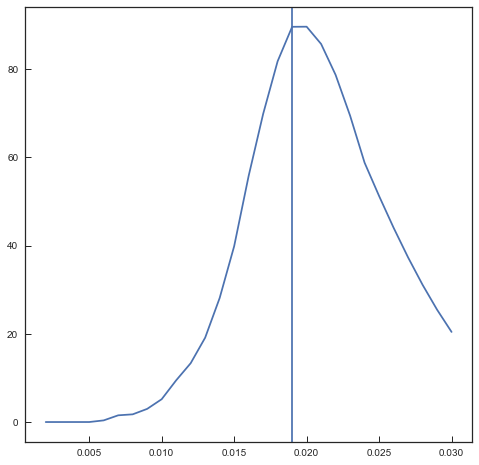

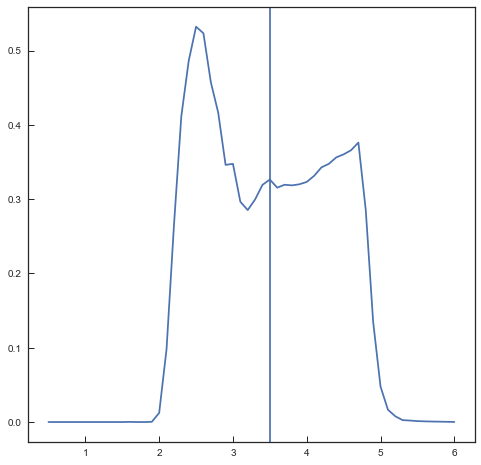

In [52]:
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
MC_fit('s39170',metal,age,tau,.019,3.5,8.7,1.022,'sim_test','../data/sim_test.npy',repeats=10)

In [53]:
m_mn, a_mn = np.load('../mcerr/sim_testmean.npy')
m_md, a_md = np.load('../mcerr/sim_testmed.npy')
m_mo, a_mo = np.load('../mcerr/sim_testmode.npy')
PZ = np.load('../mcerr/sim_testpz.npy')
Pt = np.load('../mcerr/sim_testpt.npy')
P = np.load('../mcerr/sim_testp.npy')

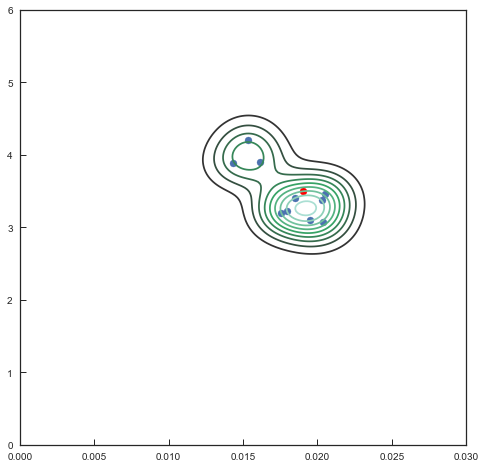

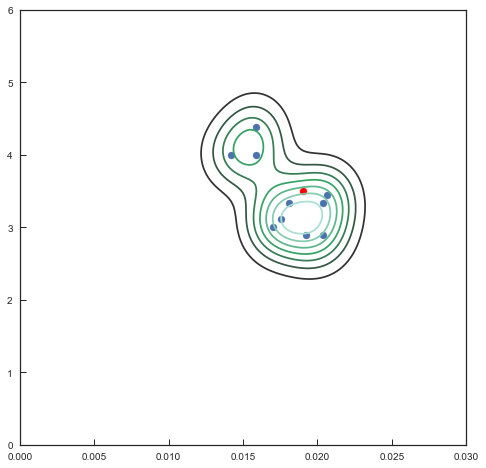

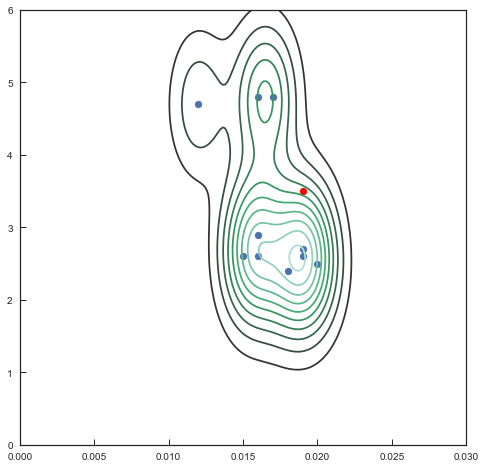

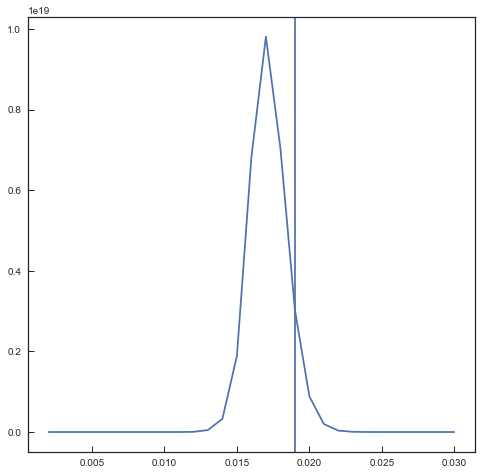

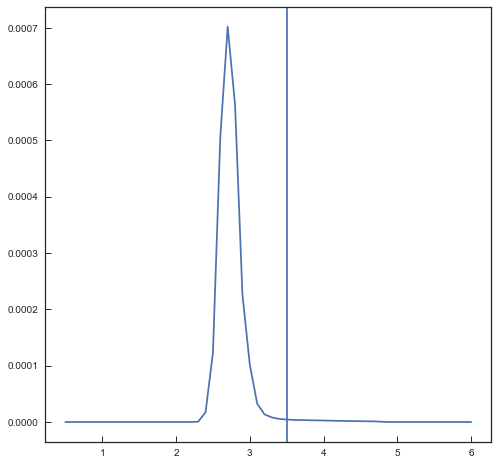

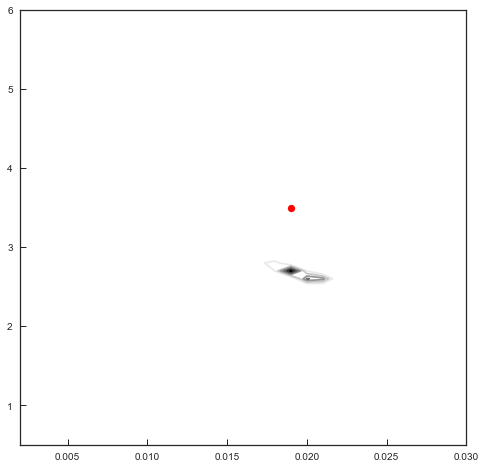

In [54]:
%matplotlib inline

M,A=np.meshgrid(metal,age)

plt.figure(figsize=[8,8])
sea.kdeplot(m_mn,a_mn)
plt.scatter(m_mn,a_mn)
plt.scatter(0.019,3.5,color = 'r')
plt.axis([0,0.03,0,6])
plt.show()
plt.close()

plt.figure(figsize=[8,8])
sea.kdeplot(m_md,a_md)
plt.scatter(m_md,a_md)
plt.scatter(0.019,3.5,color = 'r')
plt.axis([0,0.03,0,6])
plt.show()
plt.close()

plt.figure(figsize=[8,8])
sea.kdeplot(m_mo,a_mo)
plt.scatter(m_mo,a_mo)
plt.scatter(0.019,3.5,color = 'r')
plt.axis([0,0.03,0,6])
plt.show()
plt.close()


plt.figure(figsize=[8,8])
plt.plot(metal,PZ)
plt.axvline(0.019)
plt.show()
plt.close()


plt.figure(figsize=[8,8])
plt.plot(age,Pt)
plt.axvline(3.5)
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.contour(M,A,P)
plt.scatter(0.019,3.5,color = 'r')
plt.show()
plt.close()